In [3]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import mlflow
import os
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report
sns.set(color_codes=True)
%matplotlib inline
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})

mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"


In [36]:
model = "ResNet Ensemble"

eval = mlflow.search_runs(
  experiment_ids="19",
  filter_string="tags.type = 'ensemble' and tags.ensamble_method = 'bagging'",
  output_format="pandas",
).iloc[0]

quant = mlflow.search_runs(
  experiment_ids="19",
  filter_string="tags.type = 'ensemble + quantization'",
  output_format="pandas",
).iloc[2]

prun = mlflow.search_runs(
  experiment_ids="19",
  filter_string="tags.type = 'pruning' and tags.pruning_method = 'unstructured_l1'",
  output_format="pandas",
).iloc[0]

qp = mlflow.search_runs(
  experiment_ids="19",
  filter_string="tags.type = 'pruning + quantization' and tags.pruning_method = 'unstructured_l1'",
  output_format="pandas",
).iloc[0]

print(quant[AP], quant[WP])
# print(qp[AP], qp[WP])
# prun["params.model_0.25"]

7 4


In [37]:
def plot_cm(exp, file = "preds"):
    df = pd.read_csv(f"{exp['params.csv_path']}/{file}.csv")
    
    raw_preds = df.iloc[:,0:10].to_numpy()
    soft_preds = softmax(raw_preds, axis=1)
    preds = soft_preds.argmax(1)
    targs = df['targets'].to_numpy()

    cm = confusion_matrix(targs, preds)

    print(classification_report(targs, preds))
    sns.heatmap(cm)
    quantization = True if "params.quantization/weight_precision" in exp.keys() else False
    if quantization:
        plt.title(f'Quantization: WP: {exp["params.quantization/weight_precision"]} AP: {exp["params.quantization/activation_precision"]}')
    else:
        plt.title("Evaluation Test Set")

In [38]:
def get_preds(exp, file = "preds"):
    df = pd.read_csv(f"{exp['params.csv_path']}/{file}.csv")
    raw_preds = df.iloc[:,0:10].to_numpy()
    soft_preds = softmax(raw_preds, axis=1)
    preds = soft_preds.argmax(1)
    targs = df['targets'].to_numpy()

    return targs, preds

In [39]:
q_targs, q_preds = get_preds(quant, "q_preds")
targs, preds = get_preds(eval)
# p_targs, p_preds = get_preds(prun, 'p_preds')
# qp_targs, qp_preds = get_preds(qp, 'q_preds')


In [40]:
cm = confusion_matrix(targs, preds)
q_cm = confusion_matrix(q_targs, q_preds)
# p_cm = confusion_matrix(p_targs, p_preds)
# qp_cm = confusion_matrix(qp_targs, qp_preds)



cm_acc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
q_cm_acc = q_cm.astype('float') / q_cm.sum(axis=1)[:, np.newaxis]
# p_cm_acc = p_cm.astype('float') / p_cm.sum(axis=1)[:, np.newaxis]
# qp_cm_acc = qp_cm.astype('float') / qp_cm.sum(axis=1)[:, np.newaxis]


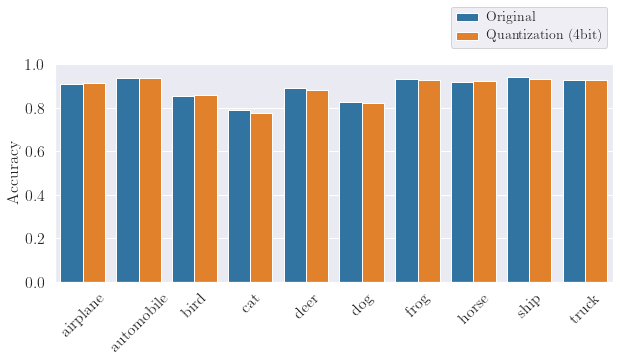

In [41]:
data = []

acc = np.diag(cm_acc)
q_acc = np.diag(q_cm_acc)
# p_acc = np.diag(p_cm_acc)
# qp_acc = np.diag(qp_cm_acc)

for i in range(len(cm_acc)):
    data.append({'type': 'Original', 'class': labels[i], 'accuracy': acc[i]})
    data.append({'type': 'Quantization (4bit)', 'class': labels[i], 'accuracy': q_acc[i]})
    # data.append({'type': 'Pruning', 'class': labels[i], 'accuracy': p_acc[i]})
    # data.append({'type': 'Quantization + Pruning', 'class': labels[i], 'accuracy': qp_acc[i]})

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 4))
plt.ylim(0, 1)

grid = sns.barplot(x="class", y="accuracy", hue="type", data=df, palette="tab10")
grid.tick_params(labelsize=16)
grid.set_xlabel("", fontsize=14)
grid.set_ylabel("Accuracy", fontsize=16)
handles, labels2 = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels2[0:])
grid.legend(loc='upper right', bbox_to_anchor=(1,1.29), ncol=1)
plt.setp(ax.get_legend().get_texts(), fontsize=14)
plt.xticks(rotation=45)
plt.savefig(f"/home/k.schwienbacher/quantization-robustness/data/class/{model}-comparison.pdf", bbox_inches='tight')


array([ 0.004,  0.   ,  0.004, -0.013, -0.006, -0.003, -0.002,  0.003,
       -0.007,  0.001])

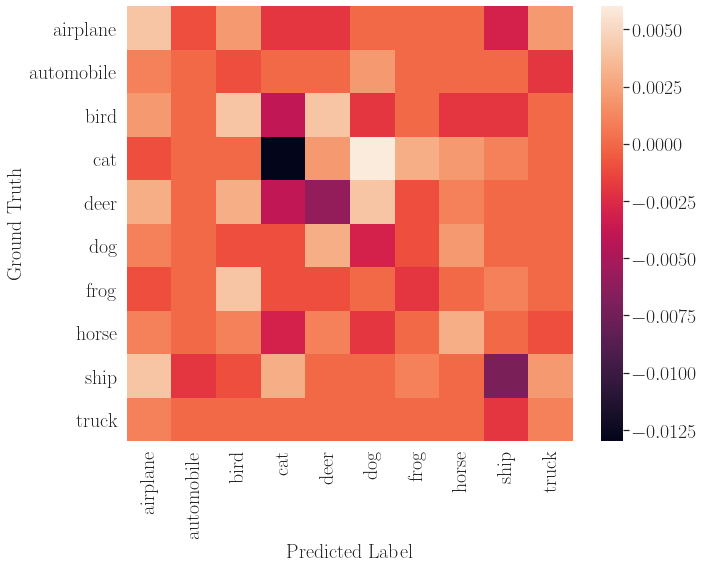

In [42]:
fig, ax = plt.subplots(figsize=(10,8))
# plt.title(f"{model}: Quantization (4bit) Accuracy Difference")

grid =sns.heatmap(q_cm_acc - cm_acc, xticklabels=labels, yticklabels=labels)

grid.tick_params(labelsize=20)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
grid.set_xlabel("Predicted Label", fontsize=20)
grid.set_ylabel("Ground Truth", fontsize=20)

plt.savefig(f"/home/k.schwienbacher/quantization-robustness/data/class/{model}-quant.pdf", bbox_inches="tight")

np.diag(q_cm_acc - cm_acc)


array([ 0.        ,  0.00972222,  0.01333333,  0.02888889,  0.02424242,
       -0.01904762, -0.03333333, -0.04444444,  0.        ,  0.00625   ,
        0.0030303 , -0.02619048,  0.01449275,  0.00833333,  0.01111111,
        0.0047619 ,  0.01333333, -0.05277778,  0.04102564, -0.01666667,
        0.1       , -0.07777778,  0.025     ,  0.02      ,  0.        ,
        0.05625   , -0.06111111,  0.        , -0.00666667,  0.02222222,
        0.18      , -0.02222222,  0.03333333,  0.0047619 ,  0.        ,
        0.01025641,  0.11666667,  0.05      ,  0.        ,  0.02222222,
        0.2       , -0.03333333, -0.1       ])

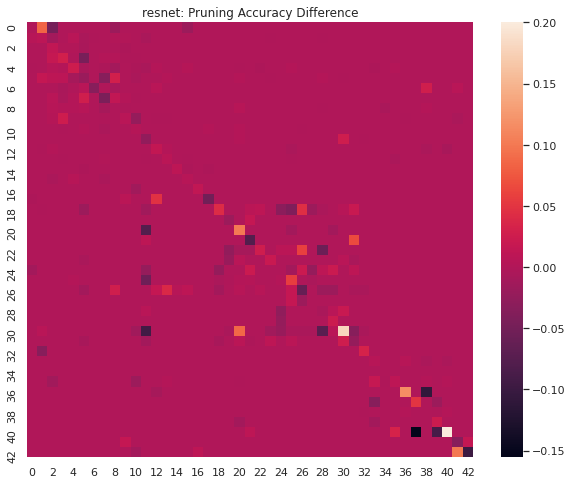

In [125]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title(f"{model}: Pruning Accuracy Difference")
sns.heatmap(p_cm_acc - cm_acc)#, xticklabels=labels, yticklabels=labels)

plt.savefig(f"/home/k.schwienbacher/quantization-robustness/data/A_gtsrb/class/{model}-prun.jpg")
np.diag(p_cm_acc - cm_acc)



array([ 0.        ,  0.01111111,  0.00666667,  0.02222222,  0.02121212,
       -0.03492063, -0.02      , -0.04888889, -0.00222222,  0.00416667,
        0.00151515, -0.02380952,  0.01594203,  0.00833333,  0.01111111,
        0.0047619 ,  0.01333333, -0.06388889,  0.04358974, -0.01666667,
        0.08888889, -0.08888889,  0.03333333,  0.03333333,  0.03333333,
        0.05625   , -0.06666667, -0.01666667, -0.00666667,  0.02222222,
        0.16666667, -0.03703704,  0.03333333,  0.0047619 ,  0.        ,
        0.0025641 ,  0.11666667,  0.03333333, -0.0057971 ,  0.01111111,
        0.18888889, -0.03333333, -0.1       ])

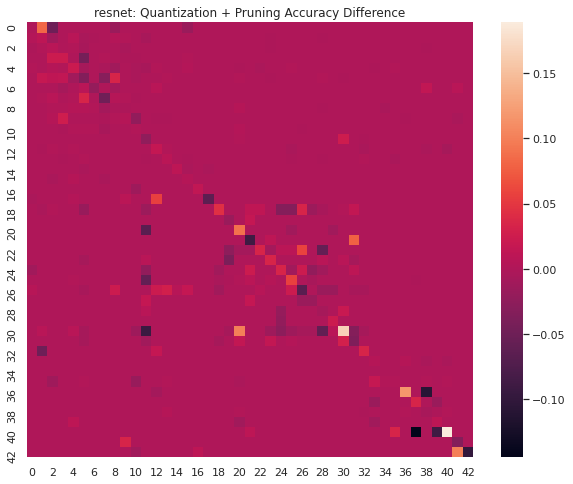

In [133]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title(f"{model}: Quantization + Pruning Accuracy Difference")
sns.heatmap(qp_cm_acc - cm_acc)#, xticklabels=labels, yticklabels=labels)

plt.savefig(f"/home/k.schwienbacher/quantization-robustness/data/A_gtsrb/class/{model}-prun-quant.jpg")

np.diag(qp_cm_acc - cm_acc)